In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
from os import listdir
from os.path import isfile, join

## Problem 1

In [5]:
mypath='data/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [39]:
class OrderBook:
    def __init__(self, filepath):
        with open(filepath, "rb") as f:
            rawdata = f.read()
        self.data = pickle.loads(rawdata)
        self.length = len(self.data)
    
    def get_ticker(self, index):
        ticker = self.data[index][0]
        return ticker
    
    def get_DataFrame(self, index, plot=False):
        oBook = self.data[index][1]
        oBook = pd.DataFrame.from_dict(oBook, orient='index').reset_index()
        oBook.columns = ['Price', 'Quantity', 'Type', 2, 3]
        oBook = oBook.sort_values(by=['Price']).reset_index(drop=True)
        if plot == True:
            fig, ax = plt.subplots(figsize=(10,5))
            
            ax.set_xlabel('Price')
            ax.set_ylabel('Quantity')
            ax.scatter(oBook['Price'], oBook['Quantity'], c=oBook['Type'] == 'B', \
                       marker='o', cmap='bwr_r')
            ax.set_xlim(oBook.Price.quantile([.01, .99]).tolist())
            ax.set_title('Distribution of orderbook')
            plt.show()
        
        return oBook

    def get_cDataFrame(self, index, plot=False):
        oBook = self.get_DataFrame(index)
        oBook['Cumsum_S'] = oBook['Quantity'][oBook['Type'] == 'S']
        oBook['Cumsum_B'] = oBook['Quantity'][oBook['Type'] == 'B']
        oBook['Cumsum_S'] = oBook.Cumsum_S.cumsum()
        oBook['Cumsum_B'] = oBook.Cumsum_B[::-1].cumsum()
        oBook['Cumsum'] = oBook['Cumsum_S'].fillna(0)- \
                            oBook['Cumsum_B'].fillna(0)
        if plot == True:
            fig, ax = plt.subplots(figsize=(10,5))
            ax.set_xlabel('Price')
            ax.set_ylabel('Quantity')
            ax.scatter(oBook['Price'], -oBook['Cumsum_B'])
            ax.scatter(oBook['Price'], oBook['Cumsum_S'])
            ax.set_xlim(oBook.Price.quantile([.01, .99]).tolist())
            ax.set_title('Cumulative distribution of orderbook')
            plt.show()
        return oBook
    
    def fit_curve(self, index, quantile=None, plot=False):
        oBook = self.get_cDataFrame(index)
        if quantile!=None:
            qTiles = oBook.Price.quantile(quantile).tolist()
            oBook = oBook[(oBook.Price > qTiles[0]) & (oBook.Price <qTiles[1])]
        
        ols = sm.OLS(oBook.Cumsum, sm.add_constant(oBook.Price.values)).fit()
        p = ols.params
        if plot == True:
            fig, ax = plt.subplots(figsize=(10,5))
            ax.set_xlabel('Price')
            ax.set_ylabel('Quantity')
            ax.scatter(oBook['Price'], oBook['Cumsum'])
            ax.plot(oBook.Price,p[0]+ p[1]* oBook.Price.values)
            ax.set_title('Curve fit to orderbook')
            plt.show()
        
        median = oBook.Price.median()

        maxID = oBook['Cumsum_B'].idxmax()
        minID = oBook['Cumsum_S'].idxmin()
        
        if (np.isnan(maxID)) or (np.isnan(minID)):
            BBO = None
        else:      
            max_price = oBook.loc[maxID]['Price']
            min_price = oBook.loc[minID]['Price']
            BBO = (max_price+min_price)/2
        return p, median

In [40]:
dataset = dict()
for i in onlyfiles:
    dataset[i] = OrderBook(mypath+i)

In [41]:
dataset.keys()

dict_keys(['SPY', 'AAPL', 'GBX', 'THO', 'C'])

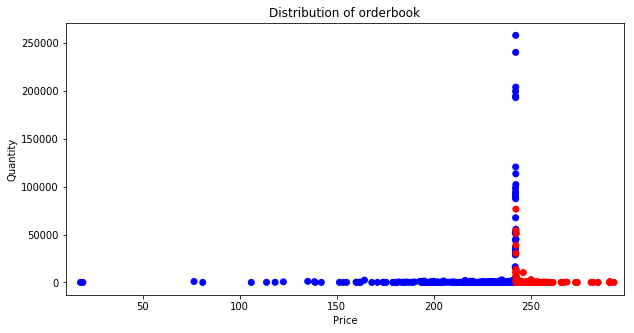

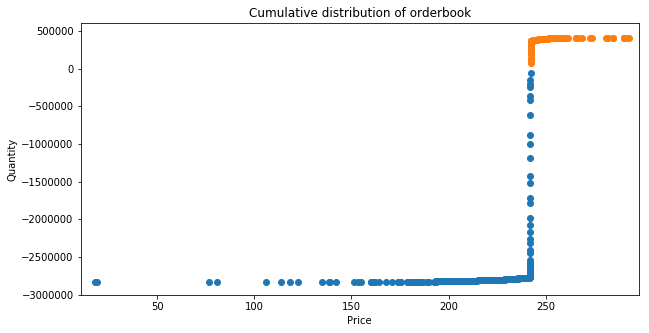

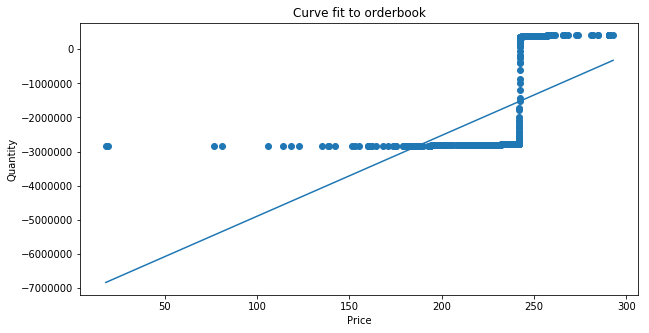

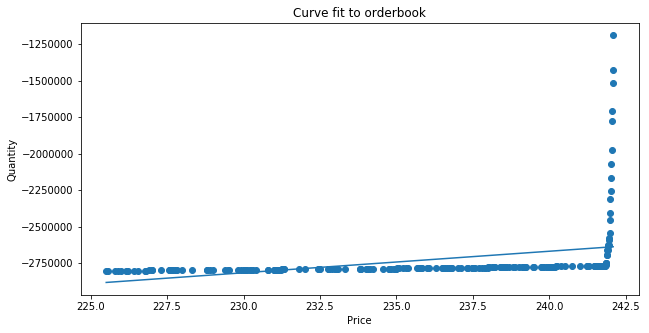

In [43]:
df = dataset['SPY'].get_DataFrame(0, plot=True)
df2 = dataset['SPY'].get_cDataFrame(0, plot=True)
p =  dataset['SPY'].fit_curve(0,quantile=[0.01,0.99], plot=True)
p, BBO =  dataset['SPY'].fit_curve(0,quantile=[0.3,0.7], plot=True)

## Problem 2

In [44]:
pValues = dict()
medianValues = dict()
tickers = dict()
for i in onlyfiles:
    pValues[i] = []
    tickers[i] = []
    medianValues[i] = []
    print(i)
    for j in range(dataset['AAPL'].length):
        p, median = dataset[i].fit_curve(j,quantile=[0.01,0.99])
        pValues[i].append(p.tolist())
        tickers[i].append(dataset[i].get_ticker(j))
        medianValues[i].append(median)
        
for i in onlyfiles:
    pValues[i] = np.array(pValues[i])
    tickers[i] = np.array(tickers[i])
    medianValues[i] = np.array(medianValues[i])

SPY
AAPL
GBX
THO
C


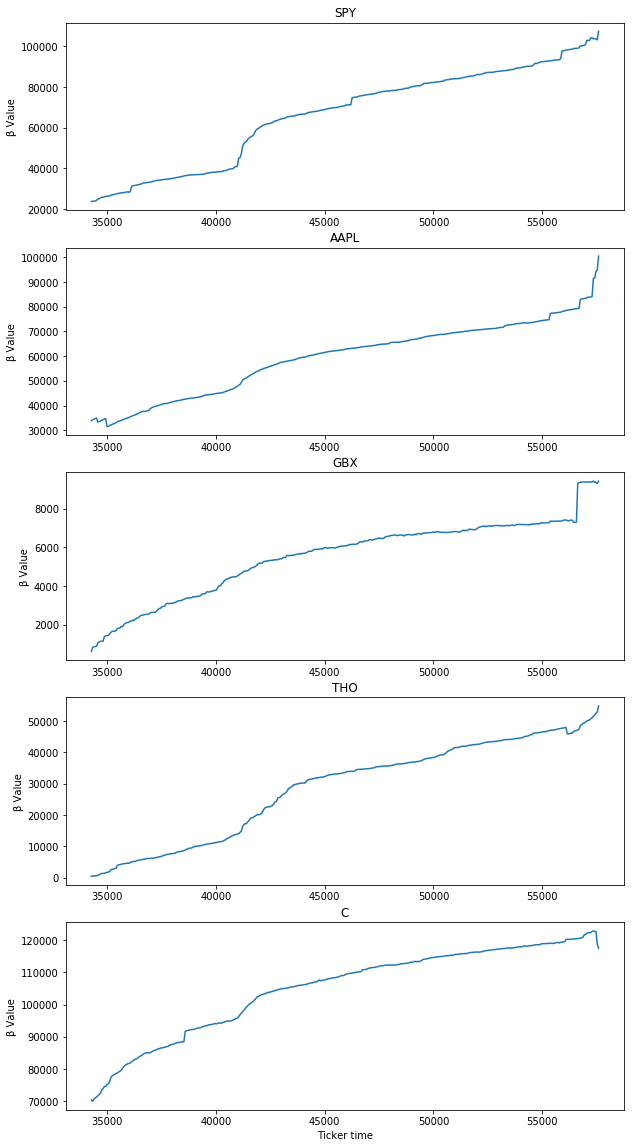

In [45]:
fig, ax = plt.subplots(5, 1, figsize=(10,20))

for i, key in enumerate(onlyfiles):
    ax[i].plot(tickers[key], pValues[key][:,1])
    ax[i].set_ylabel('β Value')
    ax[i].set_title(key)
ax[i].set_xlabel('Ticker time')
fig.tight_layout    
plt.show()

## Problem 3

We can see below that the estimation process is quite noisy.

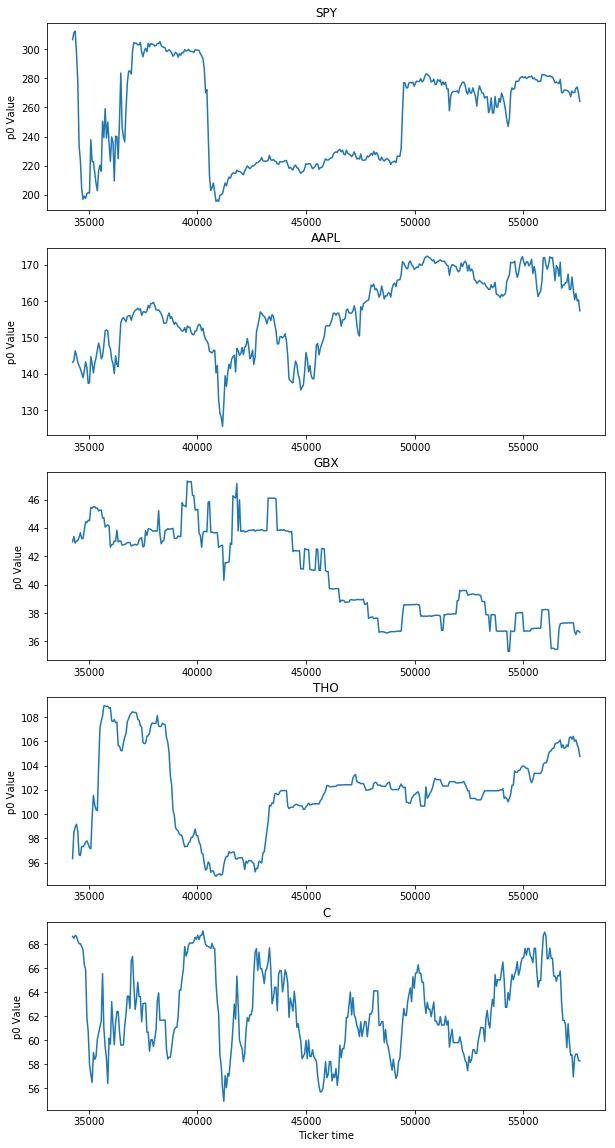

In [46]:
fig, ax = plt.subplots(5, 1, figsize=(10,20))

for i, key in enumerate(onlyfiles):
    ax[i].plot(tickers[key], -pValues[key][:,0]/pValues[key][:,1])
    ax[i].set_ylabel('p0 Value')
    ax[i].set_title(key)
ax[i].set_xlabel('Ticker time')
fig.tight_layout    
plt.show()

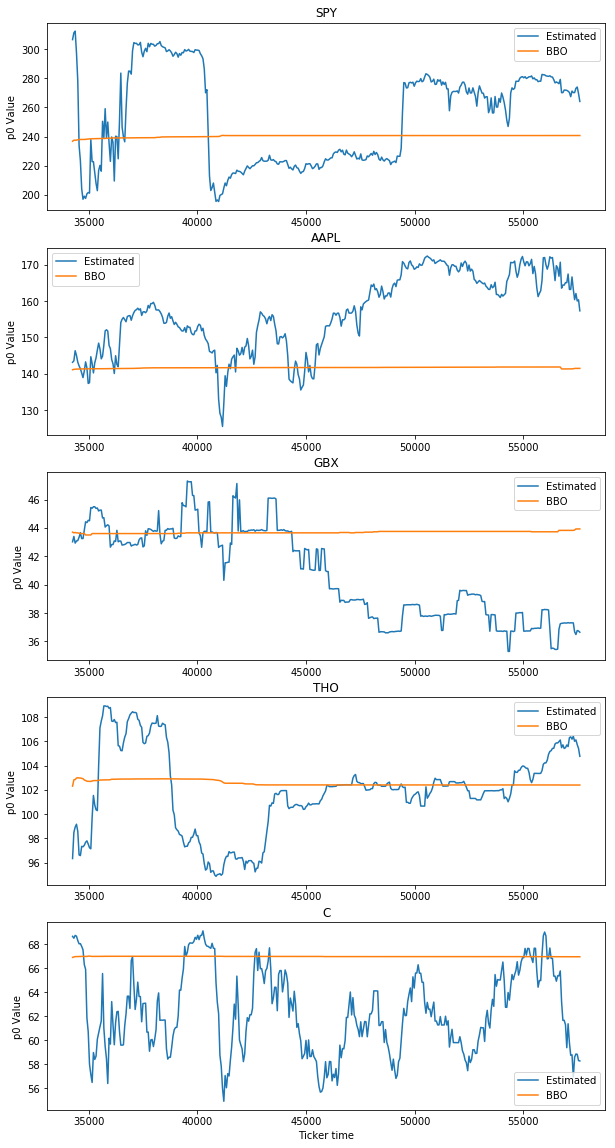

In [47]:
fig, ax = plt.subplots(5, 1, figsize=(10,20))

for i, key in enumerate(onlyfiles):
    ax[i].plot(tickers[key], -pValues[key][:,0]/pValues[key][:,1], label='Estimated')
    ax[i].plot(tickers[key], medianValues[key], label='BBO')
    ax[i].legend()
    ax[i].set_ylabel('p0 Value')
    ax[i].set_title(key)
ax[i].set_xlabel('Ticker time')
fig.tight_layout    
plt.show()

## Problem 4 

We can now show how the signal to noise ratio changes when we take a inner quartile. Which indicates that a lot of the noise is due to the linear fit in OLS not being good for larger ranges. Maybe using a logit type function would be better.

SPY
AAPL
GBX
THO
C


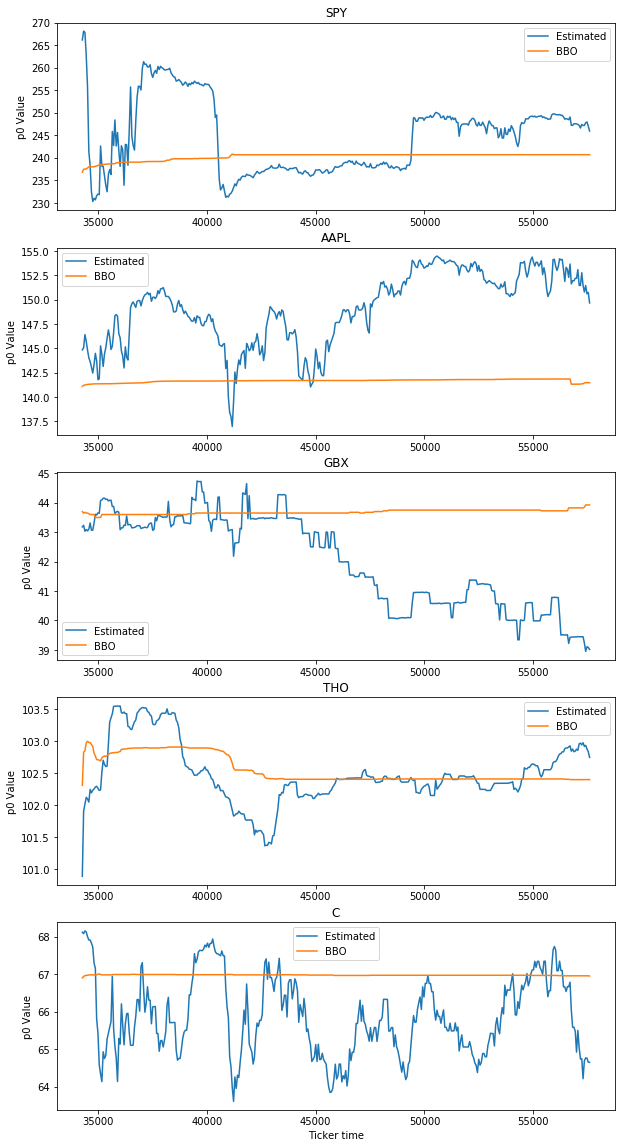

In [48]:
pValues = dict()
medianValues = dict()
tickers = dict()
for i in onlyfiles:
    pValues[i] = []
    tickers[i] = []
    medianValues[i] = []
    print(i)
    for j in range(dataset['AAPL'].length):
        p, median = dataset[i].fit_curve(j,quantile=[0.2,0.8])
        pValues[i].append(p.tolist())
        tickers[i].append(dataset[i].get_ticker(j))
        medianValues[i].append(median)
        
for i in onlyfiles:
    pValues[i] = np.array(pValues[i])
    tickers[i] = np.array(tickers[i])
    medianValues[i] = np.array(medianValues[i])
    
    
fig, ax = plt.subplots(5, 1, figsize=(10,20))

for i, key in enumerate(onlyfiles):
    ax[i].plot(tickers[key], -pValues[key][:,0]/pValues[key][:,1], label='Estimated')
    ax[i].plot(tickers[key], medianValues[key], label='BBO')
    ax[i].legend()
    ax[i].set_ylabel('p0 Value')
    ax[i].set_title(key)
ax[i].set_xlabel('Ticker time')
fig.tight_layout    
plt.show()

SPY
AAPL
GBX
THO
C


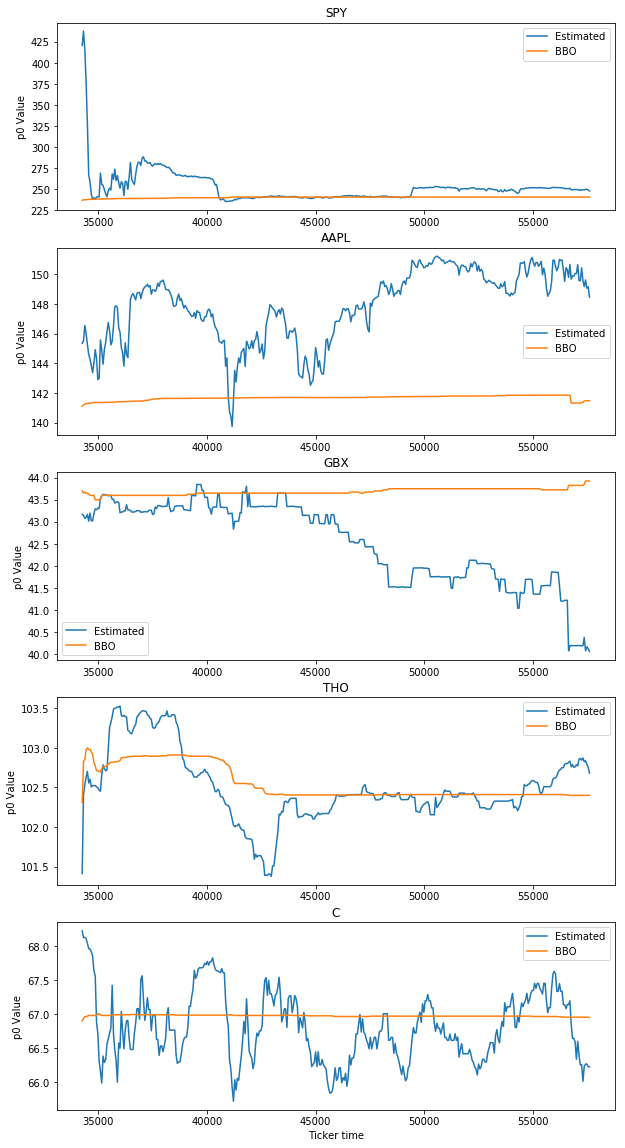

In [49]:
pValues = dict()
medianValues = dict()
tickers = dict()
for i in onlyfiles:
    pValues[i] = []
    tickers[i] = []
    medianValues[i] = []
    print(i)
    for j in range(dataset['AAPL'].length):
        p, median = dataset[i].fit_curve(j,quantile=[0.3,0.7])
        pValues[i].append(p.tolist())
        tickers[i].append(dataset[i].get_ticker(j))
        medianValues[i].append(median)
        
for i in onlyfiles:
    pValues[i] = np.array(pValues[i])
    tickers[i] = np.array(tickers[i])
    medianValues[i] = np.array(medianValues[i])
    
    
fig, ax = plt.subplots(5, 1, figsize=(10,20))

for i, key in enumerate(onlyfiles):
    ax[i].plot(tickers[key], -pValues[key][:,0]/pValues[key][:,1], label='Estimated')
    ax[i].plot(tickers[key], medianValues[key], label='BBO')
    ax[i].legend()
    ax[i].set_ylabel('p0 Value')
    ax[i].set_title(key)
ax[i].set_xlabel('Ticker time')
fig.tight_layout    
plt.show()